# FOOOF - Tutorial

<div class="alert alert-success">
FOOOF (fitting oscillations & one over f) is a module to fit neural power spectra. This tutorial covers the fundamentals of the FOOOF codebase. 
</div>

<div class="alert alert-info">
For a theoretical description of the model, go [here](01-ModelDescription.ipynb), or for a more  detailed guide through the algorithm, in code, go [here](03-FOOOFAlgorithm.ipynb).
</div>

In [1]:
# General imports
%matplotlib inline

import numpy as np

In [2]:
# Import the FOOOF object
from fooof import FOOOF

In [3]:
# Load example data to use for this tutorial (a single example power spectrum)
freqs = np.load('dat/freqs.npy')
spectrum = np.load('dat/spectrum.npy')

## FOOOF Object

Fooof, as a module, is object oriented. 

At the core, is the FOOOF object, which holds relevant data and settings as attributes, and procedures to run the FOOOF algorithm as methods. 

It's organization is similar to sklearn, with the approach being:
    - A model object is initialize with relevant settings
    - The model is fit to data
    - Results can be extracted from the object

In [4]:
# Check the docs for the FOOOF object
FOOOF?

## FOOOF Example


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.49 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.49 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):    

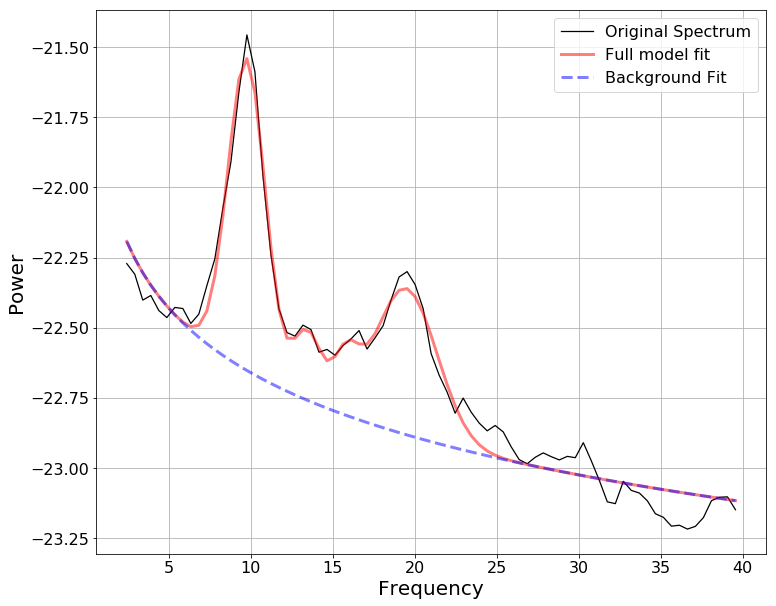

In [5]:
# Initialize FOOOF model
fm = FOOOF()

# Set the frequency range upon which to fit FOOOF
freq_range = [2, 40]

# Run FOOOF model - calculates model, plots, and prints results
fm.report(freqs, spectrum, freq_range)

The above method 'report', is a convenience method that calls a serious of FOOOF methods, first fitting the model, then printing out the results in both string form, and as a plot. Each of these methods ('fit', 'print_results' and 'plot') can each be called individually. 

In [6]:
# Alternatively, just fit the model with FOOOF.fit() (without any printing)
fm.fit(freqs, spectrum, freq_range)

# After fitting, plotting and parameter fitting can be called independently:
# fm.print_results()
# fm.plot()


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.49 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



### FOOOF Results

When the FOOOF model is calculated (either using 'fit', or with 'report'), the model fit parameters are stored as object attributes that can be accessed after fitting.

Following the sklearn convention, attributes that are fit as a result of the model have a trailing underscore:
- background\_params_
- peak\_params_
- error_
- r2_

In [7]:
# Access model fit parameters from FOOOF object, after fitting

# Background params 
print('Background Parameters: \n', fm.background_params_, '\n')

# Peak parameters
print('Peak Parameters: \n', fm.peak_params_, '\n')

# Goodness of fit measures
print('Goodness of Fit:')
print(' Error - ', fm.error_)
print(' R^2   - ', fm.r_squared_)

Background Parameters: 
 [-21.89682937   0.76346864] 

Peak Parameters: 
 [[  9.74716521   1.11125396   2.28154043]
 [ 13.46025653   0.24785595   1.68052342]
 [ 15.81191698   0.24964902   1.55741871]
 [ 19.48856681   0.52143303   3.7670429 ]] 

Goodness of Fit:
 Error -  0.0480353593963
 R^2   -  0.978171067705


### Notes on Interpreting Peak Parameters

Note that the peak parameters that are returned are not exactly the same as the parameters of the gaussians used internally to fit the peaks. 

Specifically:
- CF is the mean parameter of the gaussian (same as the gaussian)
- Amp is the amplitude of the model fit above the background slope fit [1], which is not necessarily the same as the gaussian amplitude
- BW is 2 * the standard deviation of the gaussian [2]

[1] Since the gaussians are fit together, if any gaussians overlap, than the actual height of the fit at a given point can only be assessed when considering all gaussian. To be better able to interpret amplitudes for single peak fits, we re-define the peak amplitude as above. 

[2] Standard deviation is '1 sided', returned BW is '2 sided'.

In [8]:
# The underlying gaussian parameters are also availabe from the FOOOF object
# fm._gaussian_params

# Compare the 'peak_params_', as compared to the underlying gaussian parameters
for peak, gau in zip(fm.peak_params_, fm._gaussian_params):
    print(peak, '\t', gau)

[ 9.74716521  1.11125396  2.28154043] 	 [ 9.74716521  1.11138316  1.14077022]
[ 13.46025653   0.24785595   1.68052342] 	 [ 13.46025653   0.24387152   0.84026171]
[ 15.81191698   0.24964902   1.55741871] 	 [ 15.81191698   0.1823705    0.77870936]
[ 19.48856681   0.52143303   3.7670429 ] 	 [ 19.48856681   0.52156491   1.88352145]


#### FOOOFResults object

FOOOF also has a convenience method to return all model fit results: get_results(). 

It returns all the model fit parameters, including the underlying gaussian parameters. 

Get parameters actually collects and returns these results as a FOOOFResults object (a named tuple), to keep data organized, and allow for easier collecting. 

In [9]:
# Grab each model fit result with convenience method to gather all results
bg_params, peak_params, r_squared, fit_error, gauss_params = fm.get_results()

# Get results actually returns a FOOOFResult object (a named tuple)
fres = fm.get_results()

In [10]:
# Print out the FOOOFResults
print(fres, '\n')

# From FOOOFResults, you can access the different results
print('Background Params: \n', fres.background_params)

FOOOFResult(background_params=array([-21.89682937,   0.76346864]), peak_params=array([[  9.74716521,   1.11125396,   2.28154043],
       [ 13.46025653,   0.24785595,   1.68052342],
       [ 15.81191698,   0.24964902,   1.55741871],
       [ 19.48856681,   0.52143303,   3.7670429 ]]), r_squared=0.97817106770520845, error=0.048035359396278961, gaussian_params=array([[  9.74716521,   1.11138316,   1.14077022],
       [ 13.46025653,   0.24387152,   0.84026171],
       [ 15.81191698,   0.1823705 ,   0.77870936],
       [ 19.48856681,   0.52156491,   1.88352145]])) 

Background Params: 
 [-21.89682937   0.76346864]


In [11]:
# Check the r^2 and error of the model fit
print('R-squared: \n', fm.r_squared_)
print('Fit error: \n', fm.error_)

R-squared: 
 0.978171067705
Fit error: 
 0.0480353593963


### Description of FOOOF methods and parameters

FOOOF follows the Python convention in which all user exposed settings, data, and methods are directly accessible through the object, where as 'hidden' ones have a leading underscore.

The FOOOF object contents consist of 4 main components:
- Settings (attributes)
    - User exposed settings are all set in object initialization. 
        - peak_width_limits, max_n_peaks, min_peak_amplitude, peak_threshold, background_mode, verbose
    - There are some internal settings that are not exposed at initialization. These settings are unlikely to need to be accessed by the user, but can be if desired - they are  all defined and documented in init, there should be no other settings, or 'magic numbers' in any other parts of the code.
- Data (attributes)
    - FOOOF stores the frequency vector, power spectrum, frequency range, and frequency resolution.
        - fm.freqs, fm.power_spectrum, fm.freq_range, fm.freq_res
    - During the fit procedure, interim data variable are created and used. underscore. 
- Results (attributes)
    - FOOOF follows the scipy convention in that any attributes that are result from fitting to the data are indicated by a trailing underscore
        - fm.background\_params_, fm.peak\_params\_, fm.fooofed\_spectrum\_, fm.r\_squared\_, fm.error\_
- Functions (methods)
    - Functions that operate on the FOOOF object data.
    - In addition to the exposed methods, there are some internal methods called in the fitting procedure. These methods should not be called independently, as they may depend on internal state as defined from other methods. 

In [12]:
# You can check all the user defined FOOOF settings with check_settings
#  The description parameter here is set to print out descriptions of the settings
fm.print_settings(description=True)

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                     Background Mode : fixed                                      
                           The aproach taken to fitting the background.                           
                                 Peak Width Limits : [0.5, 12.0]                                  
                             Enforced limits for peak widths, in Hz.                              
                                    Max Number of Peaks : inf                                     
                        The maximum number of peaks that can be extracted.                        
                                     Minimum Amplitude : 0.0                                      
          

### Fitting FOOOF, with different settings

In [13]:
# Load example data - a different power spectrum
freqs = np.load('dat/freqs_2.npy')
spectrum = np.load('dat/spectrum_2.npy')

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.49 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -21.4437, 1.0751                                         
                                                                                                  
                                       3 peaks were found:                                        
          

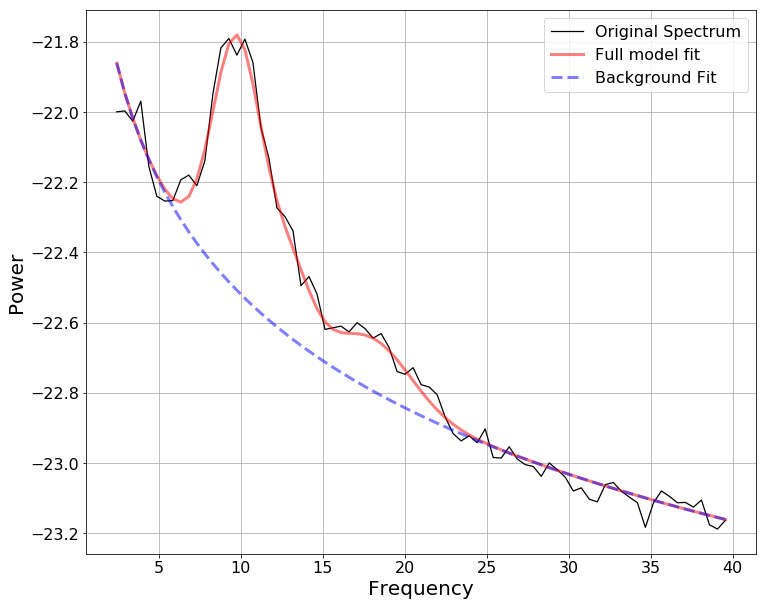

In [14]:
# Initialize FOOOF model, with different settings
fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_amplitude=0.15)

# Fit FOOOF
f_range = [2, 40]
fm.report(freqs, spectrum, f_range)

### Updating Settings

If you wish to change these settings, re-initialize the FOOOF object with new settings. Simply resetting the relevant attribute may not appropriately propragate the value, and may fail (either by erroring out, or not applying the settings properly during fit and returning erroneous results). 

### Fitting FOOOF, with background knee

In [15]:
# Load example data (LFP)
freqs = np.load('dat/freqs_lfp.npy')
spectrum = np.load('dat/spectrum_lfp.npy')

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 60 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                          Background Parameters (offset, knee, slope):                            
                                     6.3562, 47.5550, 1.8879                                      
                                                                                                  
                                       2 peaks were found:                                        
          

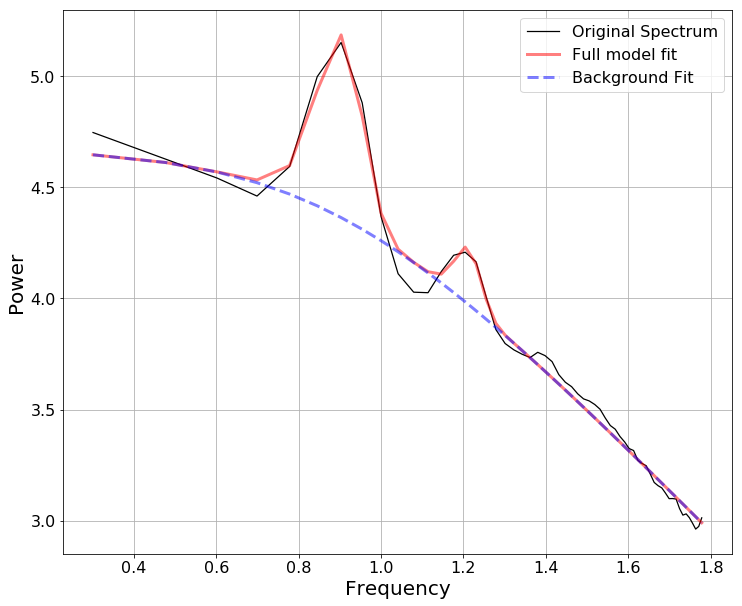

In [16]:
# Initialize FOOOF - setting to fit a knee
fm = FOOOF(peak_width_limits=[2, 8], background_mode='knee')

# Fit FOOOF model
#  Note that this time we're specifying an optional parameter to plot in log-log
fm.report(freqs, spectrum, [2, 60], plt_log=True)

### A note on interpreting the "knee" parameter

The background fit has the form:
$$BG = 10^a * \ \frac{1}{(b + f^\ \chi)}$$

The knee parameter reported above corresponds to $b$ in the equation. 

This parameter is dependent on the frequency at which the background fit transitions from horizontal to to 1/f.

To interpret this parameter as a frequency, take the $\ \chi$-th root of b, i.e.:

$$knee \ frequency = b^{1/\ \chi}$$


## FOOOF - Saving & Reports

FOOOF also has report for saving out, and loading back in, data. 

You have the option to specify which data to save. 
- results: model fit results (same as is returned in FOOOFResult)
- settings: all public settings (everything available at initialization)
- data: freqs & power spectrum

FOOOF save uses JSON files. You can specify a file name to save or append to, or pass in a valid JSON file object. 

In [17]:
# Saving FOOOF results, settings, and data
fm.save(save_results=True, save_settings=True, save_data=True)

In [18]:
# Loading FOOOF results
nfm = FOOOF()
nfm.load()

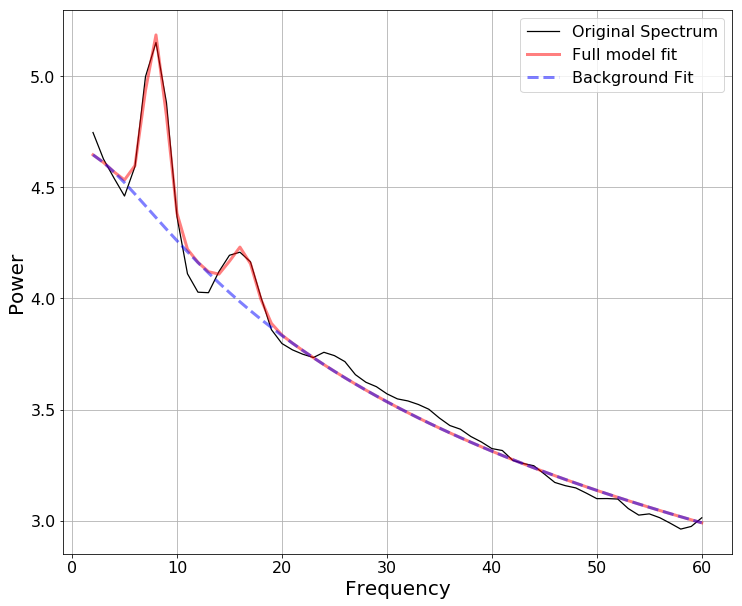

In [19]:
# Plot loaded results
nfm.plot()

### Create a Report

FOOOF also has functionality to save out a 'report' of a particular model fit.

This generates and saves a PDF which contains the same output as 'print_results', 'plot', and 'print_settings'. 

In [20]:
# Save out a report of the current FOOOF model fit & results
#  By default (with no inputs) this saves a PDF to current directory, with the name 'FOOOF_Report'
#    Add inputs to the method call to specify a file-name, and save-location
fm.save_report()

In [23]:
# Check what the generated report looks like
from IPython.display import IFrame
IFrame("img/FOOOF_Report.pdf", width=950, height=1200)

<hr>
<div class="alert alert-info">
To continue the tutorial with a more detailed guide through the algorithm, in code, go [here](03-FOOOFAlgorithm.ipynb).
</div>